# Model Building

In [16]:
import numpy as np
import pandas as pd
import seaborn as sns  
import missingno as msno
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from imblearn.combine import SMOTEENN
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [17]:
df = pd.read_excel('../data/processed/train_preprocessed.xlsx')

In [18]:
X = df.drop(columns =['responded'])
y = df['responded']

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [20]:
y_train = y_train.values
y_test = y_test.values

## Balancing the dataset

- It is essential to balance the highly imbalanced dataset. Here we are utilizing mixed sampling, specifically the SMOTE-ENN method, to address the highly imbalanced dataset. This approach combines oversampling (SMOTE) and undersampling (ENN) techniques, leveraging k-nearest neighbors to generate synthetic instances while avoiding the potential drawbacks of oversampling and undersampling individually.

In [21]:
smoteenn = SMOTEENN(random_state=42)
X_train_mixsmapled, y_train_mixsmapled = smoteenn.fit_resample(X_train, y_train)

## Initializing the Model
- Given the imbalance in the dataset, solely emphasizing accuracy may result in missed opportunities, potentially leading to financial losses for the company. Therefore, while striving for an accuracy threshold of 85% as per project requirements, this analysis prioritizes maximizing the recall of the minority class ("Yes" responses) to ensure comprehensive identification of potential customers. To strike this balance, an ensemble approach is adopted, leveraging both Random Forest Classifier and Support Vector Machines. This strategy aims to optimize both accuracy and recall concurrently, thereby enhancing the effectiveness of the propensity model without compromising on its predictive performance.

In [22]:
rf_classifier = RandomForestClassifier(random_state=42)

# Create a Linear Support Vector Machine (SVM) classifier
svm_classifier = SVC(kernel='rbf', probability=True, random_state=42)

# Ensemble the classifiers using a VotingClassifier
ensemble_classifier = VotingClassifier(estimators=[
    ('rf', rf_classifier),
    ('svm', svm_classifier)
], voting='hard')  # 'hard' for probability voting

# Fit the ensemble model on the resampled training data
ensemble_classifier.fit(X_train_mixsmapled, y_train_mixsmapled)

# Make predictions on the test set
y_pred = ensemble_classifier.predict(X_test)


### Evaluating the Model (Before Hyperparameter Tuning)

Accuracy: 0.86
classification_report:
              precision    recall  f1-score   support

          no       0.93      0.90      0.92      1077
         yes       0.41      0.52      0.46       142

    accuracy                           0.86      1219
   macro avg       0.67      0.71      0.69      1219
weighted avg       0.87      0.86      0.87      1219

Confusion Matrix:


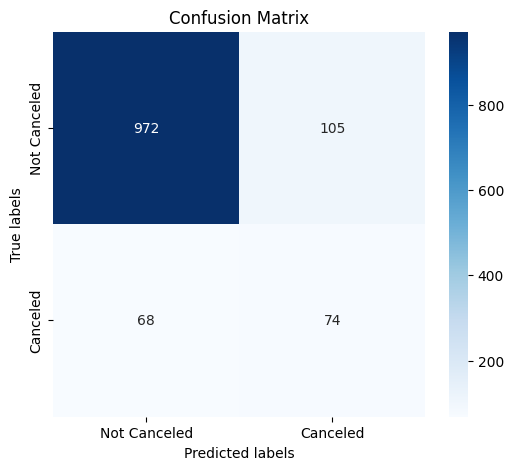

In [23]:
# Evaluate the ensemble model
accuracy = accuracy_score(y_test, y_pred)
cr = classification_report(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")
print(f"classification_report:\n{cr}")

#Visualising the Confusion Model
print("Confusion Matrix:")
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Not Canceled', 'Canceled'], 
            yticklabels=['Not Canceled', 'Canceled'])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

## Hyperparameter Tuning

In [24]:
from sklearn.model_selection import GridSearchCV

rf_param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

rf_grid_search = GridSearchCV(estimator=RandomForestClassifier(random_state=42),
                              param_grid=rf_param_grid,
                              scoring='accuracy',
                              cv=5,
                              n_jobs=-1)
rf_grid_search.fit(X_train_mixsmapled, y_train_mixsmapled)

# Get the best hyperparameters for each model
best_rf_params = rf_grid_search.best_params_

print(f"RandomForestClassifier Parameters: {best_rf_params}")

RandomForestClassifier Parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}


In [25]:
rf_classifier.set_params(**best_rf_params)

ensemble_classifier = VotingClassifier(estimators=[
    ('rf', rf_classifier),
    ('svm', svm_classifier)
], voting='hard')  # 'hard' for probability voting

ensemble_classifier.fit(X_train_mixsmapled, y_train_mixsmapled)

y_pred = ensemble_classifier.predict(X_test)

## Model Evaluation

Accuracy: 0.86
classification_report:
              precision    recall  f1-score   support

          no       0.93      0.90      0.92      1077
         yes       0.41      0.52      0.46       142

    accuracy                           0.86      1219
   macro avg       0.67      0.71      0.69      1219
weighted avg       0.87      0.86      0.87      1219

Confusion Matrix:


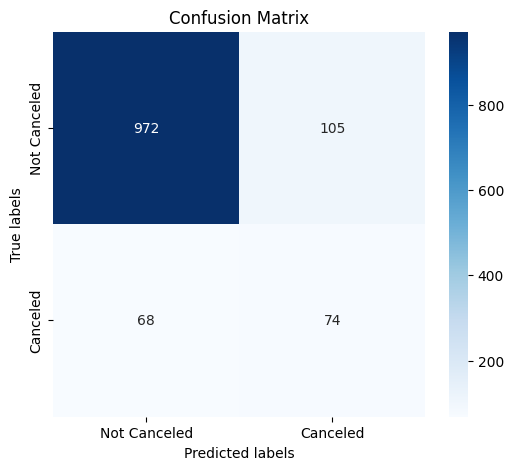

In [26]:
# Evaluate the ensemble model
accuracy = accuracy_score(y_test, y_pred)
cr = classification_report(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")
print(f"classification_report:\n{cr}")

#Visualising the Confusion Model
print("Confusion Matrix:")
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Not Canceled', 'Canceled'], 
            yticklabels=['Not Canceled', 'Canceled'])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.savefig('../visuals/model_evaluation_confusion_matrix.png', bbox_inches='tight', dpi=300) 
plt.show()

### Prediciting the target for the 'test' dataset with the created Model 

In [28]:
import sys
sys.path.append('../pipeline')  
from preprocess import preprocess_pipeline  

test_df = pd.read_excel('../data/raw/test.xlsx')

In [32]:
import joblib
test_df['id'] = 1
test_df_encoded = preprocess_pipeline(test_df)

model = joblib.load('../models/ensemble_classifier_model.pkl')

y_pred = model.predict(test_df_encoded)
y_pred

d:\Projects\basic-ml-projects\insurance-marketing-optimisation-propensity-model\notebooks\../pipeline\preprocess.py:142: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["pdays"] = np.select(
d:\Projects\basic-ml-projects\insurance-marketing-optimisation-propensity-model\notebooks\../pipeline\preprocess.py:148: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["pmonths"] = np.select(


array(['no', 'yes', 'no', ..., 'no', 'no', 'no'], dtype=object)

In [40]:
unique_values, counts = np.unique(y_pred, return_counts=True)

# Combine unique values and counts into a dictionary
value_counts = dict(zip(unique_values, counts))

print(value_counts)

{'no': 31398, 'yes': 821}


In [46]:
test_df_encoded['responded_predicted'] = y_pred
# Save the modified DataFrame back to a new CSV file
test_df_encoded.to_csv('../data/processed/testingCandidate.csv', index=False)